# Configs

In [237]:
CONFIG = {
    # --- Develop
    "is_test": True,
    "test_sample_per_label": 2,
    
    # --- Training data
    "train_data": "/Users/dauduchieu/Desktop/iSE_CBM_CIN/data/test-20k.csv",
    "test_data": "/Users/dauduchieu/Desktop/iSE_CBM_CIN/data/test-20k.csv",
    "text_col": "abstract_text",
    "label_col": "target",
    "label_map": {
        "BACKGROUND": "background",
        "OBJECTIVE": "objective",
        "METHODS": "methods",
        "RESULTS": "results",
        "CONCLUSIONS": "conclusions"
    },
    
    # Concept generation
    "concepts": {
        "keyword_concepts": {
            "0": ["aim", "develop", "cancer", "common"],
            "1": ["aim", "develop", "cancer", "common"],
            "2": ["aim", "develop", "cancer", "common"]
        },
        "abstract_concepts": {
            "a": {
                "Adverse": ["aim", "develop"], 
                "Treatment": ["turn", "cold"], 
                "Intense": ["hate"]
            },
            "b": {
                "Reactions": ["aim", "develop"], 
                "Failure": ["turn", "cold"], 
                "Dislike": ["hate"]
            },
        }
    },
    
    # Concept score
    "nli_model_name": "xlnet-base-cased",
    
    # CIN
    "backbone_model_name": "xlnet-base-cased",
}

In [238]:
import pandas as pd

train_df = pd.read_csv(CONFIG["train_data"])
train_df = train_df[[CONFIG["text_col"], CONFIG["label_col"]]]
train_df = train_df.rename(columns={CONFIG["text_col"]: "text", CONFIG["label_col"]: "label"})

train_df["label"] = train_df["label"].map(CONFIG["label_map"])

In [239]:
train_df.sample(5)

,text,label
2653,The GPs experienced challenges when trying to ...,results
943,Participants and their families will receive t...,background
1433,Patients with stage II or III gastric adenocar...,methods
1568,The proportion of patients free from recurrent...,results
2075,During 3years of follow-up we recorded exacerb...,methods


In [240]:
if CONFIG["is_test"]:
    train_df = train_df.groupby("label").sample(CONFIG["test_sample_per_label"]).reset_index(drop=True)

In [241]:
train_df.shape

(10, 2)

# Concepts Generation

# Concepts Scoring

In [242]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import accuracy_score
from tqdm.auto import tqdm
import os

class NLIModel:
    def __init__(self, model_name_or_path="bert-base-uncased", num_labels=2, max_length=256):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.max_length = max_length
        print(f"Loading NLI model: {model_name_or_path}")

        # Load tokenizer + model
        self.tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
        self.model = AutoModel.from_pretrained(model_name_or_path).to(self.device)

        # Fix pad_token if missing (GPT2/XLNet)
        if self.tokenizer.pad_token is None:
            if hasattr(self.tokenizer, "eos_token") and self.tokenizer.eos_token is not None:
                self.tokenizer.pad_token = self.tokenizer.eos_token
                print(f" > pad_token set to eos_token: {self.tokenizer.pad_token}")
            else:
                self.tokenizer.add_special_tokens({'pad_token': '[PAD]'})
                print(f" > Added new pad_token: [PAD]")
                self.model.resize_token_embeddings(len(self.tokenizer))

        # Hidden size & classifier
        hidden_size = self.model.config.hidden_size
        self.classifier = nn.Linear(hidden_size, num_labels).to(self.device)
        print(f"Model ready on {self.device}, hidden size: {hidden_size}")

    def mean_pooling(self, outputs, attention_mask):
        if not hasattr(outputs, "last_hidden_state"):
            raise ValueError(f"Model {self.model.__class__.__name__} has no last_hidden_state")
        token_embeddings = outputs.last_hidden_state
        mask = attention_mask.unsqueeze(-1)  # (B, L, 1)
        return (token_embeddings * mask).sum(1) / mask.sum(1)

    def forward(self, input_ids, attention_mask):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        emb = self.mean_pooling(outputs, attention_mask)
        logits = self.classifier(emb)
        return logits

    def score(self, text: str, concept: str) -> float:
        self.model.eval()
        self.classifier.eval()
        with torch.no_grad():
            inputs = self.tokenizer(text, concept,
                                    return_tensors="pt",
                                    truncation=True,
                                    padding=True,
                                    max_length=self.max_length).to(self.device)
            logits = self.forward(inputs["input_ids"], inputs["attention_mask"])
            prob = torch.softmax(logits, dim=1)[0][1].item()
        return prob

    def batch_score(self, text: str, concepts: list[str]):
        if not concepts: return []
        self.model.eval()
        self.classifier.eval()
        with torch.no_grad():
            inputs = self.tokenizer([text]*len(concepts), concepts,
                                    return_tensors="pt",
                                    truncation=True,
                                    padding=True,
                                    max_length=self.max_length).to(self.device)
            logits = self.forward(inputs["input_ids"], inputs["attention_mask"])
            probs = torch.softmax(logits, dim=1)[:, 1].cpu().tolist()
        return probs

    def save_model(self, output_dir: str):
        """Save tokenizer, model, and classifier"""
        os.makedirs(output_dir, exist_ok=True)
        self.model.save_pretrained(output_dir)
        self.tokenizer.save_pretrained(output_dir)
        torch.save(self.classifier.state_dict(), os.path.join(output_dir, "classifier.pt"))
        print(f"NLIModel saved to {output_dir}")


In [243]:
nli_model = NLIModel(model_name_or_path='xlnet-base-cased')

Loading NLI model: xlnet-base-cased
Model ready on cpu, hidden size: 768


# Concepts Interpretable Network

In [244]:
import torch
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer

class TextEncoder(nn.Module):
    def __init__(self, model_name: str, device=None):
        super().__init__()
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model_name = model_name
        
        # Load tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        
        # Fix padding for models without pad_token
        if self.tokenizer.pad_token is None:
            if hasattr(self.tokenizer, "eos_token") and self.tokenizer.eos_token is not None:
                self.tokenizer.pad_token = self.tokenizer.eos_token
                print(f"Warning: Set pad_token to eos_token: {self.tokenizer.eos_token}, model {model_name}")
            else:
                self.tokenizer.add_special_tokens({'pad_token': '[PAD]'})
                print(f"Warning: Added pad_token '[PAD]' to tokenizer, model {model_name}")

        # Load model
        self.model = AutoModel.from_pretrained(model_name).to(self.device)
        
        # Resize embeddings if tokenizer was extended
        if len(self.tokenizer) > self.model.config.vocab_size:
            self.model.resize_token_embeddings(len(self.tokenizer))
            print(f"Resized model embeddings to {len(self.tokenizer)}")
        
        self.model.eval()  # frozen encoder by default

    def get_hidden_size(self) -> int:
        return self.model.config.hidden_size

    @torch.no_grad()
    def encode(self, texts: list[str]):
        """
        Encode a list of texts into embeddings (B, H) using mean pooling.
        """
        # Ensure texts is a list
        if isinstance(texts, str):
            texts = [texts]

        # Tokenize
        tokens = self.tokenizer(
            texts,
            padding=True,
            truncation=True,
            return_tensors="pt",
            max_length=512
        ).to(self.device)

        outputs = self.model(**tokens)

        # Make sure last_hidden_state exists
        if not hasattr(outputs, "last_hidden_state"):
            raise ValueError(f"Model {self.model_name} did not return last_hidden_state (cannot pool)")

        last_hidden = outputs.last_hidden_state  # (B, L, H)
        attention_mask = tokens.get("attention_mask", None)  # (B, L) or None

        # Mean pooling with attention mask
        if attention_mask is not None:
            attention_mask = attention_mask.unsqueeze(-1)  # (B, L, 1)
            pooled = (last_hidden * attention_mask).sum(dim=1) / attention_mask.sum(dim=1)
            # print(f"Warning: Performing mean pooling with attention mask for model {self.model_name}")
        else:
            pooled = last_hidden.mean(dim=1)

        return pooled  # (B, H)

In [245]:
from torch.utils.data import Dataset
class CINDataset(Dataset):
    def __init__(self, texts, labels, label_map):
        self.texts = texts
        self.labels = [label_map[l] for l in labels]
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        return {
            "text": self.texts[idx], 
            "label": torch.tensor(self.labels[idx], dtype=torch.long), 
            "idx": idx
        }

In [246]:
import torch.nn.functional as F
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.metrics import classification_report
from sklearn.model_selection import ParameterGrid
import copy
import json
import math

class CIN(nn.Module):
    def __init__(self, 
        keyword_concepts:list[str], 
        abstract_concepts:list[str], 
        label_concepts:list[str],
        nli_scorer: NLIModel,
        semantic_model_name: str = 'bert-base-uncased',
        emb_dim:int=128,
        attn_dim:int=64,
    ):
        super(CIN, self).__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        self.kw_concepts = keyword_concepts
        self.ab_concepts = abstract_concepts
        self.lb_concepts = label_concepts
        self.nli_scorer = nli_scorer
        self.emb_dim = emb_dim
        self.attn_dim = attn_dim
        self.semantic_model_name = semantic_model_name
        
        # 1. Semantic Encoder (SBERT)
        print(f"Loading semantic model from: {self.semantic_model_name}...")
        self.text_encoder = TextEncoder(self.semantic_model_name)
        self.s_dim = self.text_encoder.get_hidden_size()
        print(f"  > Semantic embedding dimension: {self.s_dim}")
        
        # 2. Frozen Projector (SBERT dim -> emb_dim)
        self.warm_start_projector = nn.Linear(self.s_dim, emb_dim, bias=False)
        self.warm_start_projector.requires_grad_(False)
        
        # 3. Learnable Embeddings (emb_dim) & Biases
        self.kw_embs = nn.Parameter(torch.randn(len(self.kw_concepts), emb_dim) * 0.02)
        self.ab_embs = nn.Parameter(torch.randn(len(self.ab_concepts), emb_dim) * 0.02)
        self.lb_embs = nn.Parameter(torch.randn(len(self.lb_concepts), emb_dim) * 0.02)
        self.b_ab = nn.Parameter(torch.zeros(len(self.ab_concepts)))
        self.b_lb = nn.Parameter(torch.zeros(len(self.lb_concepts)))
        
        # 4. Learnable Attention Layers
        self.Wq = nn.Linear(emb_dim, attn_dim, bias=False)
        self.Wk = nn.Linear(emb_dim, attn_dim, bias=False)
        self.Uq = nn.Linear(emb_dim, attn_dim, bias=False)
        self.Uk = nn.Linear(emb_dim, attn_dim, bias=False)
        
        # 5. Contextual Gating MLP
        gate_in_dim = self.s_dim + 1 + emb_dim
        self.gate_mlp = nn.Sequential(
            nn.Linear(gate_in_dim, max(128, gate_in_dim // 4)),
            nn.ReLU(),
            nn.Linear(max(128, gate_in_dim // 4), 1),
            nn.Sigmoid()
        )
        
        # 6. Projector for InfoNCE LOSS
        self.infonce_projector = nn.Linear(emb_dim, self.s_dim, bias=False)
        
        self.to(self.device)
        
        # 7. Init Semantic Buffers
        with torch.no_grad():
            s_kw_raw = self.text_encoder.encode(self.kw_concepts)
            s_ab_raw = self.text_encoder.encode(self.ab_concepts)
            s_lb_raw = self.text_encoder.encode(self.lb_concepts)
            
            self.register_buffer('s_kw_raw', s_kw_raw)
            self.register_buffer('s_ab_raw', s_ab_raw)
            self.register_buffer('s_lb_raw', s_lb_raw)

            # s_kw_128 = self.warm_start_projector(s_kw_raw)
            # s_ab_128 = self.warm_start_projector(s_ab_raw)
            # s_lb_128 = self.warm_start_projector(s_lb_raw)

        # self.kw_embs.data.copy_(s_kw_128.data)
        # self.ab_embs.data.copy_(s_ab_128.data)
        # self.lb_embs.data.copy_(s_lb_128.data)

        # 8. Internal Cache
        self.train_kw_cache = None
        self.train_ab_cache = None
        self.train_text_semantic_cache = None
        self.sbert_cache_flags = None

    def _propagation_score(self, lower_embs, lower_scores, upper_embs, W_q, W_k):
        Q = W_q(upper_embs); K = W_k(lower_embs)
        raw_attn = torch.matmul(Q, K.T) / math.sqrt(self.attn_dim)
        scaled_attn = raw_attn * lower_scores.unsqueeze(0)
        attn_weights = torch.softmax(scaled_attn, dim=1)
        upper_scores = torch.matmul(attn_weights, lower_scores.unsqueeze(-1)).squeeze(-1)
        return upper_scores, attn_weights

    def _compute_layer_nli_scores(self, text:str, concepts:list[str], cache, text_idx, is_training):
        if is_training and cache is not None:
            cached_scores_row = cache[text_idx]
            if np.all(cached_scores_row != -1.0):
                return torch.tensor(cached_scores_row, device=self.device, dtype=torch.float32)
            scores_list = self.nli_scorer.batch_score(text, concepts)
            cache[text_idx] = scores_list
            return torch.tensor(scores_list, device=self.device, dtype=torch.float32)
        else:
            scores_list = self.nli_scorer.batch_score(text, concepts)
            return torch.tensor(scores_list, device=self.device, dtype=torch.float32)

    def _init_cache(self, num_samples):
        print(f"Initializing caches for {num_samples} samples...")
        self.train_kw_cache = np.full((num_samples, len(self.kw_concepts)), -1.0, dtype=np.float32)
        self.train_ab_cache = np.full((num_samples, len(self.ab_concepts)), -1.0, dtype=np.float32)
        self.train_text_semantic_cache = torch.zeros((num_samples, self.s_dim), device=self.device)
        self.sbert_cache_flags = torch.zeros(num_samples, dtype=torch.bool, device=self.device)
        print(" > Caches initialized.")

    def _get_text_sbert(self, text, text_idx, is_training):
        if is_training and text_idx is not None and self.train_text_semantic_cache is not None:
            if self.sbert_cache_flags[text_idx]: 
                return self.train_text_semantic_cache[text_idx]
            else:
                emb = self.text_encoder.encode([text])[0]
                self.train_text_semantic_cache[text_idx] = emb
                self.sbert_cache_flags[text_idx] = True
                return emb
        return self.text_encoder.encode([text])[0]
    
    def _compute_semantic_infonce_loss(self, tau=0.07):
        E_all = torch.cat([self.kw_embs, self.ab_embs, self.lb_embs], dim=0)
        S_all_raw = torch.cat([self.s_kw_raw, self.s_ab_raw, self.s_lb_raw], dim=0)
        e_proj = F.normalize(self.infonce_projector(E_all), dim=-1)
        s_norm = F.normalize(S_all_raw, dim=-1)
        sim = e_proj @ s_norm.T
        logits = sim / tau
        targets = torch.arange(sim.shape[0], device=sim.device)
        loss = F.cross_entropy(logits, targets)
        return loss
    
    def forward(self, text: str, text_idx: int = None, is_training=False):
        h_text = self._get_text_sbert(text, text_idx, is_training)
        z_kw = self._compute_layer_nli_scores(text, self.kw_concepts, self.train_kw_cache, text_idx, is_training)
        d_ab = self._compute_layer_nli_scores(text, self.ab_concepts, self.train_ab_cache, text_idx, is_training)
        r_ab, kw_ab_attn = self._propagation_score(self.kw_embs, z_kw, self.ab_embs, self.Wq, self.Wk)
        r_ab = r_ab + self.b_ab
        beta_list = []
        for j in range(len(self.ab_concepts)):
             gate_in = torch.cat([h_text, r_ab[j].unsqueeze(0), self.ab_embs[j]], dim=0)
             beta_list.append(self.gate_mlp(gate_in))
        beta_ab = torch.cat(beta_list).squeeze(-1)
        z_ab = beta_ab * d_ab + (1 - beta_ab) * r_ab
        z_lb, ab_lb_attn = self._propagation_score(self.ab_embs, z_ab, self.lb_embs, self.Uq, self.Uk)
        z_lb = z_lb + self.b_lb
        return {"kw_scores": z_kw, "ab_scores": z_ab, "lb_logits": z_lb, 
                "beta_ab": beta_ab, "kw_ab_attn": kw_ab_attn, "ab_lb_attn": ab_lb_attn}

    def train_model(self, train_texts, train_labels, val_texts=None, val_labels=None, 
                    epochs=5, batch_size=32, lr=1e-3, semantic_weight=0.1, 
                    is_new_training_data=True, verbose=True):
        if is_new_training_data or self.train_kw_cache is None: self._init_cache(len(train_texts))
        label_map = {lb: i for i, lb in enumerate(self.lb_concepts)}
        train_loader = DataLoader(CINDataset(train_texts, train_labels, label_map), 
                                  batch_size=batch_size, shuffle=True)
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()
        for epoch in range(epochs):
            self.train()
            total_loss = 0
            loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=verbose)
            for batch in loop:
                batch_logits = []
                for i, text in enumerate(batch["text"]):
                    out = self.forward(text, text_idx=batch["idx"][i].item(), is_training=True)
                    batch_logits.append(out["lb_logits"])
                cls_loss = criterion(torch.stack(batch_logits), batch["label"].to(self.device))
                sem_loss = self._compute_semantic_infonce_loss()
                loss = cls_loss + semantic_weight * sem_loss
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                if verbose: loop.set_postfix(loss=f"{loss.item():.4f}", cls=f"{cls_loss.item():.4f}", sem=f"{sem_loss.item():.4f}")
            if verbose: print(f"Epoch {epoch+1} Avg Loss: {total_loss/len(train_loader):.4f}")
            if val_texts and val_labels and verbose: self.evaluate(val_texts, val_labels, verbose=False)

    def evaluate(self, texts, labels, verbose=True):
        self.eval()
        label_map = {lb: i for i, lb in enumerate(self.lb_concepts)}
        true_labels, pred_labels = [], []
        if verbose: print("Evaluating...")
        with torch.no_grad():
            iterator = tqdm(texts, leave=False) if verbose else texts
            for i, text in enumerate(iterator):
                true_labels.append(label_map[labels[i]])
                pred_labels.append(torch.argmax(self.forward(text)["lb_logits"]).item())
        acc = (np.array(true_labels) == np.array(pred_labels)).mean()
        if verbose:
            print("\n=== Classification Report ===")
            print(classification_report(true_labels, pred_labels, target_names=self.lb_concepts, digits=4))
            print(f"Validation Accuracy: {acc:.4f}")
        return acc

    def grid_search(self, train_texts, train_labels, val_texts, val_labels, 
                    param_grid={'lr': [1e-3, 5e-4], 'epochs': [3, 5]}, 
                    batch_size=32, semantic_weight=0.1):
        print("Pre-filling caches for Grid Search (Optimized)...")
        self._init_cache(len(train_texts))
        self.eval()
        with torch.no_grad():
             for i, text in enumerate(tqdm(train_texts, desc="Caching")):
                 self.forward(text, text_idx=i, is_training=True)
        best_acc, best_params, initial_state = -1.0, None, copy.deepcopy(self.state_dict())
        grid = ParameterGrid(param_grid)
        print(f"\nStarting Grid Search with {len(grid)} combinations...")
        for params in grid:
            print(f"\n Testing: {params}")
            self.load_state_dict(copy.deepcopy(initial_state))
            self.train_model(train_texts, train_labels, epochs=params['epochs'], lr=params['lr'], 
                             batch_size=batch_size, semantic_weight=semantic_weight,
                             is_new_training_data=False, verbose=False)
            val_acc = self.evaluate(val_texts, val_labels, verbose=False)
            print(f"  -> Val Acc: {val_acc:.4f}")
            if val_acc > best_acc:
                best_acc, best_params, best_state = val_acc, params, copy.deepcopy(self.state_dict())
        print(f"\n=== Best Params: {best_params} | Best Acc: {best_acc:.4f} ===")
        self.load_state_dict(best_state)

    def interpretable_predict(self, text, top_k=3, visual_plot=True, contrast=0.5):
        self.eval()
        with torch.no_grad(): out = self.forward(text)
        lb_probs = torch.softmax(out["lb_logits"], dim=0)
        pred_idx = torch.argmax(lb_probs).item()
        print(f"\n=== Interpretation for: '{text}' ===")
        print(f"> Prediction: [{self.lb_concepts[pred_idx]}] ({lb_probs[pred_idx]:.2%})\n")
        print(f"> Top {top_k} Abstract Concepts (with Gating β):")
        top_ab = torch.topk(out["ab_scores"], k=min(top_k, len(self.ab_concepts)))
        for i in range(len(top_ab.indices)):
            idx = top_ab.indices[i]
            beta = out["beta_ab"][idx].item()
            print(f"  - {self.ab_concepts[idx]:<25} | Score: {top_ab.values[i]:.4f} | β: {beta:.2f} ({'NLI' if beta>0.5 else 'Prop'})")
        print("")
        self._print_top_k("Keyword", self.kw_concepts, out["kw_scores"], top_k)
        if visual_plot: self._plot_graph(out, contrast)

    def show_learned_attention(self, contrast=1.0):
        self.eval()
        with torch.no_grad():
            Q_kw = self.Wq(self.ab_embs); K_kw = self.Wk(self.kw_embs)
            att_kw_ab = (torch.matmul(Q_kw, K_kw.T) / math.sqrt(Q_kw.shape[1])).softmax(dim=1) 
            Q_ab = self.Uq(self.lb_embs); K_ab = self.Uk(self.ab_embs)
            att_ab_lb = (torch.matmul(Q_ab, K_ab.T) / math.sqrt(Q_ab.shape[1])).softmax(dim=1)
        def get_filtered_indices(sim, ratio, dim):
            n = sim.shape[dim]
            if ratio >= 1.0 or n < 2: return torch.arange(n, device=self.device)
            n_keep = max(2, int(n * ratio))
            mean_sims = sim.mean(dim=1-dim)
            idx = torch.argsort(mean_sims)
            return torch.sort(torch.cat([idx[:n_keep//2], idx[-n_keep + n_keep//2:]])).values
        kw_idx = get_filtered_indices(att_kw_ab, contrast, dim=1) 
        ab_idx = get_filtered_indices(att_ab_lb, contrast, dim=1)
        fig, axes = plt.subplots(1, 2, figsize=(20, 6))
        sns.heatmap(att_kw_ab[:, kw_idx].cpu().numpy(), xticklabels=[self.kw_concepts[i] for i in kw_idx.cpu().numpy()], 
                    yticklabels=self.ab_concepts, cmap="viridis", ax=axes[0])
        axes[0].set_title(f"Learned Attention: Abstract attending to Keywords (Contrast: {contrast:.0%})")
        sns.heatmap(att_ab_lb[:, ab_idx].cpu().numpy(), xticklabels=[self.ab_concepts[i] for i in ab_idx.cpu().numpy()], 
                    yticklabels=self.lb_concepts, cmap="magma", ax=axes[1], annot=True, fmt=".2f")
        axes[1].set_title(f"Learned Attention: Label attending to Abstracts (Contrast: {contrast:.0%})")
        plt.tight_layout()
        plt.show()

    def _print_top_k(self, name, concepts, scores, k):
        top = torch.topk(scores, k=min(k, len(concepts)))
        print(f"> Top {k} {name}:")
        for i in range(len(top.indices)):
            print(f"  - {concepts[top.indices[i]]:<25} | Score: {top.values[i]:.4f}")
        print("")

    def _plot_graph(self, out, contrast):
        G = nx.DiGraph()
        def get_nodes(scores, ratio):
            n = max(2, int(len(scores) * ratio))
            idx = torch.argsort(scores)
            return torch.cat([idx[:n//2], idx[-n + n//2:]]).unique()
        kw_idx, ab_idx = get_nodes(out["kw_scores"], contrast), get_nodes(out["ab_scores"], contrast)
        lb_idx = torch.arange(len(self.lb_concepts), device=self.device)
        for i in kw_idx: G.add_node(f"K{i}", layer=0, label=self.kw_concepts[i], color=out["kw_scores"][i].item())
        for i in ab_idx: G.add_node(f"A{i}", layer=1, label=self.ab_concepts[i], color=out["ab_scores"][i].item())
        for i in lb_idx: G.add_node(f"L{i}", layer=2, label=self.lb_concepts[i], color=out["lb_logits"][i].item())
        for a in ab_idx:
            for k in kw_idx:
                if (w := out["kw_ab_attn"][a, k].item()) > 0.01: G.add_edge(f"K{k}", f"A{a}", weight=w)
        for l in lb_idx:
            for a in ab_idx:
                if (w := out["ab_lb_attn"][l, a].item()) > 0.01: G.add_edge(f"A{a}", f"L{l}", weight=w)
        pos = nx.multipartite_layout(G, subset_key="layer")
        labels = {n: G.nodes[n]['label'] for n in G.nodes}
        colors = [G.nodes[n]['color'] for n in G.nodes]
        edge_weights = [d['weight'] for _,_,d in G.edges(data=True)]
        plt.figure(figsize=(14, 8))
        nx.draw_networkx_nodes(G, pos, node_color=colors, cmap='RdYlGn', node_size=2000, alpha=0.9)
        nx.draw_networkx_labels(G, pos, labels=labels, font_size=9)
        nx.draw_networkx_edges(G, pos, width=[w * 5 for w in edge_weights], alpha=0.4, edge_color='gray', arrows=True)
        plt.title(f"Propagation Graph (Contrast: {contrast:.0%})")
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
    def save_model(self, path: str):
        print(f"Saving CIN model to {path}...")
        if not os.path.exists(path):
            os.makedirs(path)
            
        # 1. Save NLI Scorer
        nli_path = os.path.join(path, "nli_model")
        self.nli_scorer.save_model(nli_path)
        
        # 2. Save metadata CIN
        config = {
            "keyword_concepts": self.kw_concepts,
            "abstract_concepts": self.ab_concepts,
            "label_concepts": self.lb_concepts,
            "semantic_model_name": self.semantic_model_name,
            "emb_dim": self.emb_dim,
            "attn_dim": self.attn_dim,
        }
        config_path = os.path.join(path, "cin_config.json")
        with open(config_path, 'w') as f:
            json.dump(config, f, indent=4)
        print(f"  > CIN config saved to {config_path}")
            
        # 3. Save state_dict CIN
        model_path = os.path.join(path, "cin_model.pth")
        torch.save(self.state_dict(), model_path)
        print(f"  > CIN state_dict saved to {model_path}")
        
        print("CIN model saved successfully.")

In [247]:
import json

def load_cin(path: str) -> CIN:
    print(f"Loading CIN model from {path}...")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # 1. Load metadata
    config_path = os.path.join(path, "cin_config.json")
    if not os.path.exists(config_path):
        raise FileNotFoundError(f"Config file not found: {config_path}")
    with open(config_path, 'r') as f:
        config = json.load(f)
    print("  > Config loaded.")

    # 2. Load NLI Scorer
    nli_path = os.path.join(path, "nli_model")
    if not os.path.exists(nli_path):
        raise FileNotFoundError(f"NLI model directory not found: {nli_path}")
    
    loaded_nli_scorer = NLIModel(model_name_or_path=nli_path)
    print("  > NLI scorer loaded.")

    # 3. Load CIN
    print("  > Initializing CIN model structure...")
    model = CIN(
        keyword_concepts=config["keyword_concepts"],
        abstract_concepts=config["abstract_concepts"],
        label_concepts=config["label_concepts"],
        nli_scorer=loaded_nli_scorer,
        semantic_model_name=config["semantic_model_name"],
        emb_dim=config["emb_dim"],
        attn_dim=config["attn_dim"]
    )
    
    # 4. Load state_dict weight CIN
    model_path = os.path.join(path, "cin_model.pth")
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model state_dict not found: {model_path}")
        
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    
    print("CIN model loaded successfully.")
    return model

In [248]:
keyword_concept_list = []
abstract_concept_list = []
label_concept_list = []

c_kw_c = CONFIG["concepts"]["keyword_concepts"]
c_ab_c = CONFIG["concepts"]["abstract_concepts"]

for l in c_kw_c.values():
    keyword_concept_list.extend(l)

for l in c_ab_c.keys():
    abstract_concept_list.extend(list(c_ab_c[l].keys()))

label_concept_list = list(CONFIG["label_map"].values())

print(keyword_concept_list)
print(abstract_concept_list)
print(label_concept_list)    

['aim', 'develop', 'cancer', 'common', 'aim', 'develop', 'cancer', 'common', 'aim', 'develop', 'cancer', 'common']
['Adverse', 'Treatment', 'Intense', 'Reactions', 'Failure', 'Dislike']
['background', 'objective', 'methods', 'results', 'conclusions']


In [250]:
cin_model = CIN(
    keyword_concepts=keyword_concept_list,
    abstract_concepts=abstract_concept_list,
    label_concepts=label_concept_list,
    nli_scorer=nli_model,
    semantic_model_name='xlnet-base-cased',
    emb_dim=128,
    attn_dim=64
)

Loading semantic model from: xlnet-base-cased...
  > Semantic embedding dimension: 768


In [251]:
from sklearn.model_selection import train_test_split

g_train_df, g_val_df = train_test_split(train_df, test_size=0.15, random_state=42)

g_train_texts = g_train_df["text"].to_list()
g_train_labels = g_train_df["label"].to_list()

g_val_texts = g_val_df["text"].to_list()
g_val_labels = g_val_df["label"].to_list()

In [252]:
cin_model.grid_search(
    g_train_texts, g_train_labels, 
    g_val_texts, g_val_labels, 
    param_grid={
        'lr': [1e-3, 5e-4],
        'epochs': [3, 5]
    }, 
    semantic_weight=0.1,
    batch_size=64
)

Pre-filling caches for Grid Search (Optimized)...
Initializing caches for 8 samples...
 > Caches initialized.


Caching: 100%|██████████| 8/8 [00:03<00:00,  2.31it/s]



Starting Grid Search with 4 combinations...

 Testing: {'epochs': 3, 'lr': 0.001}


  -> Val Acc: 0.0000

 Testing: {'epochs': 3, 'lr': 0.0005}


  -> Val Acc: 0.0000

 Testing: {'epochs': 5, 'lr': 0.001}


  -> Val Acc: 0.0000

 Testing: {'epochs': 5, 'lr': 0.0005}


  -> Val Acc: 0.0000

=== Best Params: {'epochs': 3, 'lr': 0.001} | Best Acc: 0.0000 ===


True label: background

=== Interpretation for: 'EBV-encoded latent membrane protein 1 ( EBV-LMP1 ) is an important oncogenic protein for nasopharyngeal carcinoma ( NPC ) and has been shown to engage a plethora of signaling pathways .' ===
> Prediction: [objective] (20.05%)

> Top 5 Abstract Concepts (with Gating β):
  - Failure                   | Score: 0.9821 | β: 0.98 (NLI)
  - Dislike                   | Score: 0.9798 | β: 0.98 (NLI)
  - Treatment                 | Score: 0.9793 | β: 0.98 (NLI)
  - Adverse                   | Score: 0.9770 | β: 0.98 (NLI)
  - Reactions                 | Score: 0.9769 | β: 0.98 (NLI)

> Top 5 Keyword:
  - common                    | Score: 0.9841
  - common                    | Score: 0.9841
  - common                    | Score: 0.9841
  - develop                   | Score: 0.9803
  - develop                   | Score: 0.9803



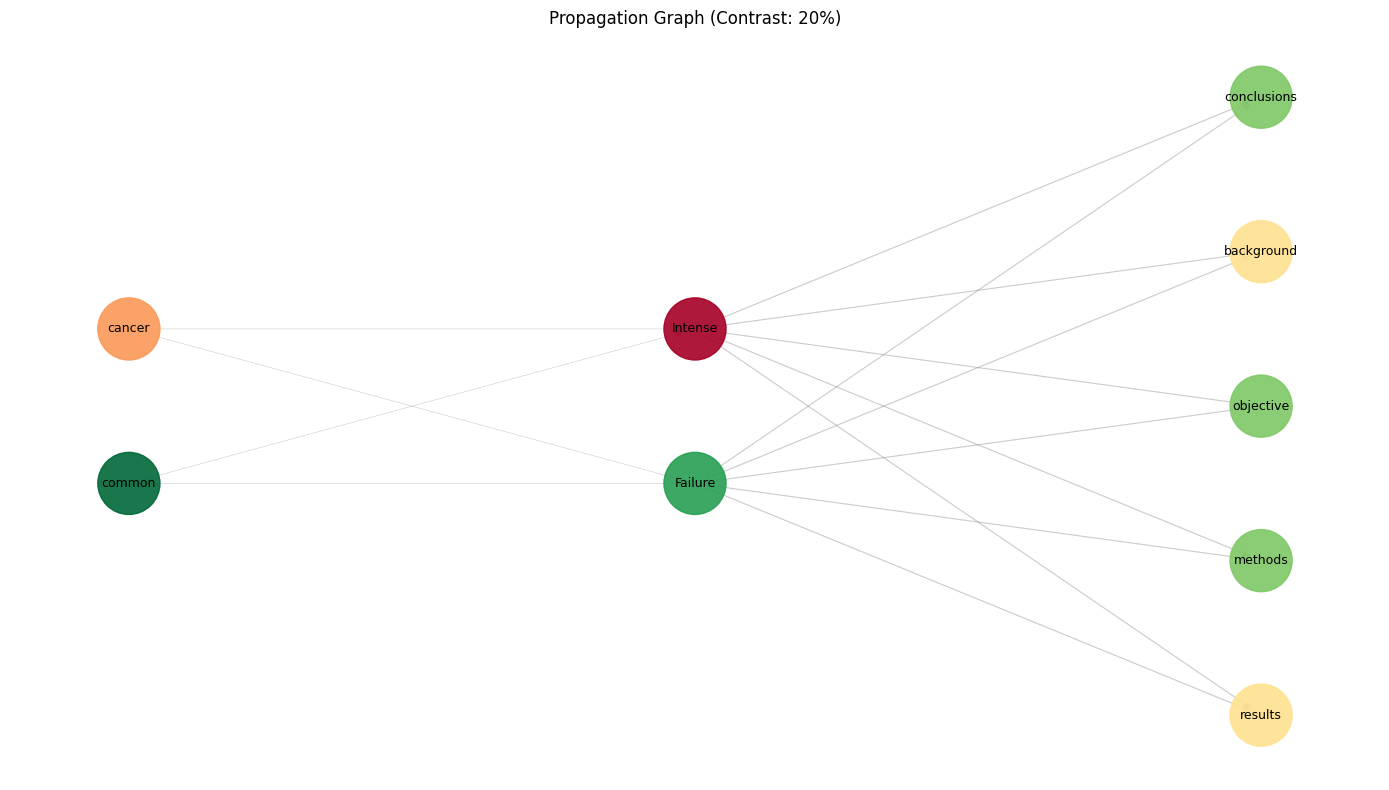

In [253]:
text = train_df["text"].to_list()[0]
true_label = train_df["label"].to_list()[0]
print(f"True label: {true_label}")
cin_model.interpretable_predict(text, top_k=5, visual_plot=True, contrast=0.2)

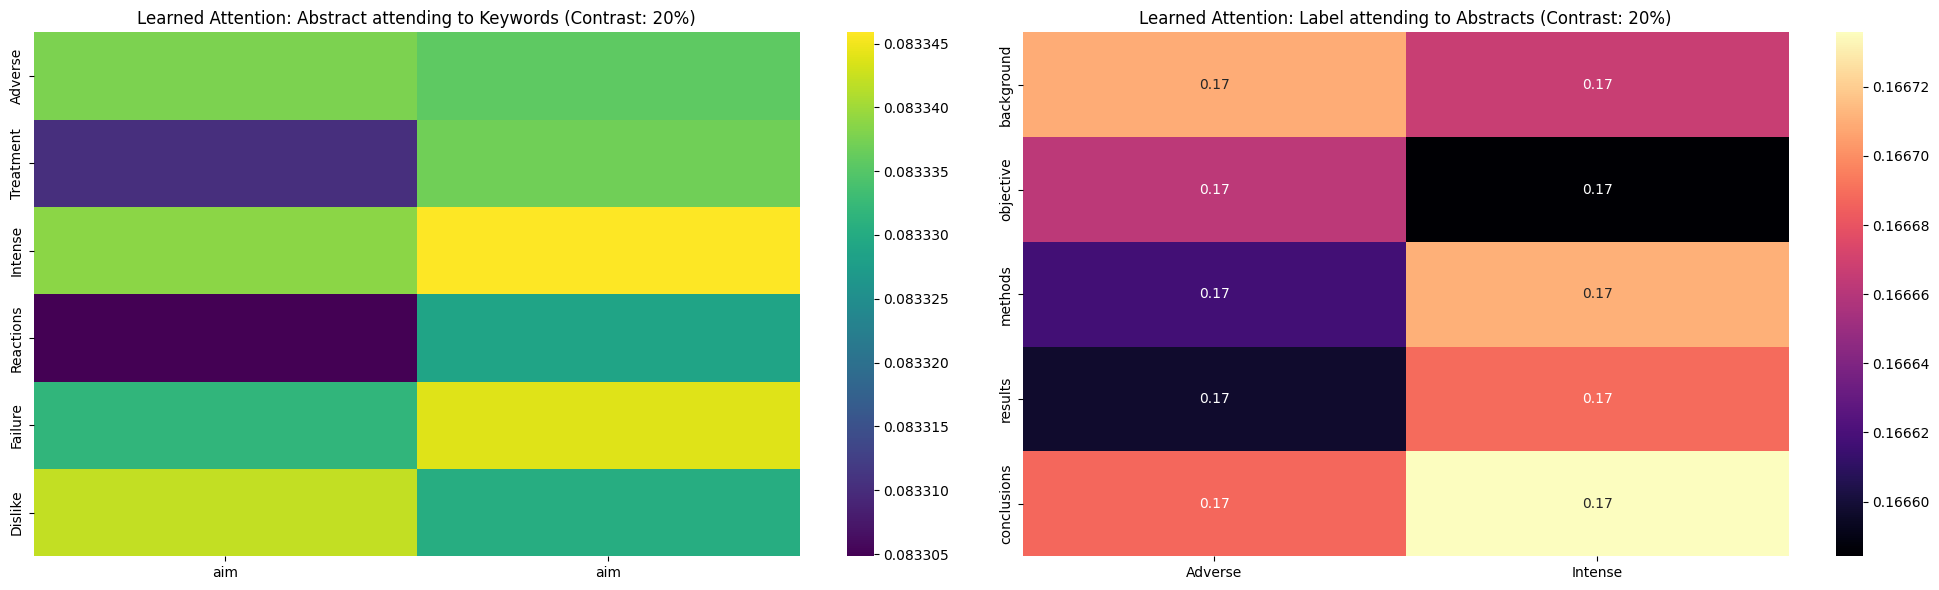

In [254]:
cin_model.show_learned_attention(contrast=0.2)

In [255]:
save_dir = "./saved_cin_model"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
# Save CIN model state_dict
cin_model.save_model(save_dir)

Saving CIN model to ./saved_cin_model...
NLIModel saved to ./saved_cin_model/nli_model
  > CIN config saved to ./saved_cin_model/cin_config.json
  > CIN state_dict saved to ./saved_cin_model/cin_model.pth
CIN model saved successfully.


## Test CIN

In [256]:
import pandas as pd

train_df = pd.read_csv(CONFIG["train_data"])
train_df = train_df[[CONFIG["text_col"], CONFIG["label_col"]]]
train_df = train_df.rename(columns={CONFIG["text_col"]: "text", CONFIG["label_col"]: "label"})

train_df["label"] = train_df["label"].map(CONFIG["label_map"])

In [257]:
test_df = pd.read_csv(CONFIG["test_data"])
test_df = test_df[[CONFIG["text_col"], CONFIG["label_col"]]]
test_df = test_df.rename(columns={CONFIG["text_col"]: "text", CONFIG["label_col"]: "label"})

test_df["label"] = test_df["label"].map(CONFIG["label_map"])

In [258]:
test_df.sample(2)

,text,label
2160,Fewer number of patients in the fentanyl group...,results
327,The present study aims to compare the movement...,objective


In [259]:
if CONFIG["is_test"]:
    test_df = test_df.groupby("label").sample(CONFIG["test_sample_per_label"]).reset_index(drop=True)

In [260]:
test_df.shape

(10, 2)

In [261]:
cin = load_cin(save_dir)

Loading CIN model from ./saved_cin_model...
  > Config loaded.
Loading NLI model: ./saved_cin_model/nli_model
Model ready on cpu, hidden size: 768
  > NLI scorer loaded.
  > Initializing CIN model structure...
Loading semantic model from: xlnet-base-cased...
  > Semantic embedding dimension: 768
CIN model loaded successfully.


In [262]:
cin.evaluate(test_df["text"].to_list(), test_df["label"].to_list(), verbose=True)

Evaluating...



=== Classification Report ===
              precision    recall  f1-score   support

  background     0.0000    0.0000    0.0000         2
   objective     0.3333    0.5000    0.4000         2
     methods     0.0000    0.0000    0.0000         2
     results     0.0000    0.0000    0.0000         2
 conclusions     0.0000    0.0000    0.0000         2

    accuracy                         0.1000        10
   macro avg     0.0667    0.1000    0.0800        10
weighted avg     0.0667    0.1000    0.0800        10

Validation Accuracy: 0.1000


/Users/dauduchieu/Desktop/iSE_CBM_CIN/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/dauduchieu/Desktop/iSE_CBM_CIN/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/dauduchieu/Desktop/iSE_CBM_CIN/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

np.float64(0.1)